This is the basis of my submission to the [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition. This notebook was started based on the lessons on machine learning curated on [Kaggle Learn](https://www.kaggle.com/learn/machine-learning) then refined further to achieve more accuracy and additional visualization.

<br/>
I also was able to learn some new techniques from the following kernels:
* [Laurenstc's kernel](https://www.kaggle.com/laurenstc/top-2-of-leaderboard-advanced-fe)
* [Aleksandrs Gehsbargs's kernel](https://www.kaggle.com/agehsbarg/top-10-0-10943-stacking-mice-and-brutal-force)
* [Serigne's kernel](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
* [Massquantity's kernel](https://www.kaggle.com/massquantity/all-you-need-is-pca-lb-0-11421-top-4)
* [Fkstepz's kernel](https://www.kaggle.com/fkstepz/step-by-step-house-prices-prediction)

<br/>
The notebook is arranged into the following sections:<br/>
1. Prep<br/>
2. Exploratory Visualization and Data Cleansing<br/>
3. Feature Engineering<br/>
4. Modeling<br/>
5. Submit results

In [1]:
from IPython.display import Image
url = 'http://ep60qmdjq8-flywheel.netdna-ssl.com/wp-content/uploads/2009/08/commercial-real-estate.jpg'
Image(url=url,width=800, height=600)

# 1. Prep
Import all libraries, define functions, and load data.

**Import all libraries and define functions**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBRegressor
import warnings

# Turn off the nagging warnings from sklearn and seaborn
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# Identify numeric columns
def numeric_cols(data_frame):
    numeric_cols = [cname for cname in data_frame.columns if 
                                data_frame[cname].dtype in ['int64', 'float64']]
    return(numeric_cols)

# Identify categorical columns with low cardinality (a small number of distinct values)
def low_cardinality_cols(data_frame):
    low_cardinality_cols = [cname for cname in data_frame.columns if 
                                data_frame[cname].nunique() >= 50 and
                                data_frame[cname].dtype == "object"]
    print(low_cardinality_cols)
    return(low_cardinality_cols)

# Identify columns with missing data
def cols_with_missing(data_frame):
    cols_with_missing = [cname for cname in data_frame.columns 
                                 if data_frame[cname].isnull().any()]
    return(cols_with_missing)

**Load the data**

In [5]:
!ls

data  predicting-iowa-house-prices.ipynb


In [7]:
# Read core training and test data
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

print("Train set size:", train_data.shape)
print("Test set size:", test_data.shape)

Train set size: (1460, 81)
Test set size: (1459, 80)


# 2. Exploratory Visualization and Data Cleansing

**Confirm column overlap between train and test**

While it can be assumed that all of the columns match in these data sets, I still wanted to get the code in here to confirm that SalePrice is the only column difference between the two.

In [8]:
print("Columns in training data but not in testing data")
print([x for x in train_data.columns if x not in test_data.columns])
print("Columns in testing data but not in training data")
print([x for x in test_data.columns if x not in train_data.columns])

Columns in training data but not in testing data
['SalePrice']
Columns in testing data but not in training data
[]


**View statistical properties of the data**

In [9]:
# view the data and get the statistical properties
train_data.describe(include = 'all')
#train_data.info()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


In [10]:
train_data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


**Drop the Id column since it isn't worth keeping**

By determining that all values of this column are unique I feel comfortable dropping it

In [11]:
if train_data['Id'].nunique() == train_data['Id'].size:
    train_data.drop(['Id'],axis=1,inplace=True)

**View correlation of data**

View the correlation map of data with clean colors and elimination of the duplicate display on the upper right hand corner of the chart that comes with it by default.

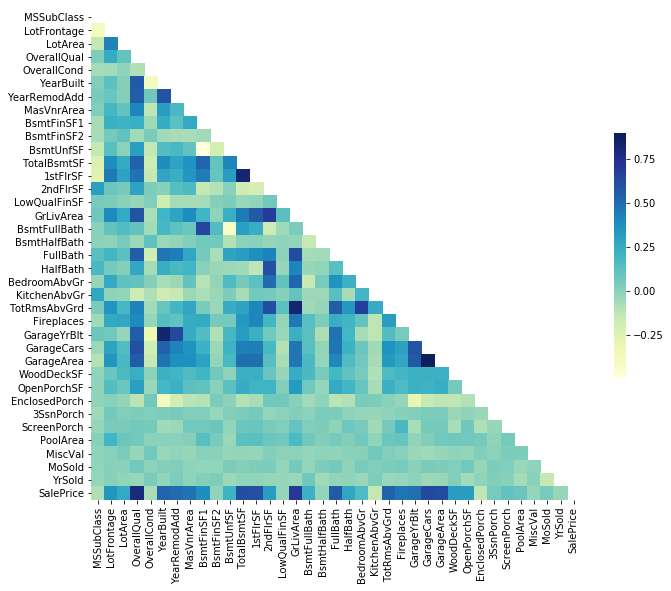

In [12]:
corrmat = train_data.corr()
plt.subplots(figsize=(12,9))
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrmat, mask=mask, vmax=0.9, cmap="YlGnBu",
            square=True, cbar_kws={"shrink": .5})

**Get the data into  better working form**

In [13]:
# Drop houses where the target is missing
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)

# pull all data data into target (y) and predictors (X)
train_y = train_data.SalePrice

# only keep data that is either numeric or has a low cardinality for categorical data
# in this case it keeps most all of the columns
targeted_train_X_cols = low_cardinality_cols(train_data) + numeric_cols(train_data)
train_X = train_data[targeted_train_X_cols]
train_X = train_X.drop(['SalePrice'], axis=1)
train_X = pd.get_dummies(train_X)

# Treat the test data in the same way as training data. In this case, pull same columns.
targeted_test_X_cols = low_cardinality_cols(test_data) + numeric_cols(test_data)
test_X = test_data[targeted_test_X_cols]
test_X = pd.get_dummies(test_X)

# inner join the data to ensure the exact columns included are aligned
train_X, test_X = train_X.align(test_X,
                                join='inner', 
                                axis=1)

[]
[]


**Plot all significant features along with a regression line**

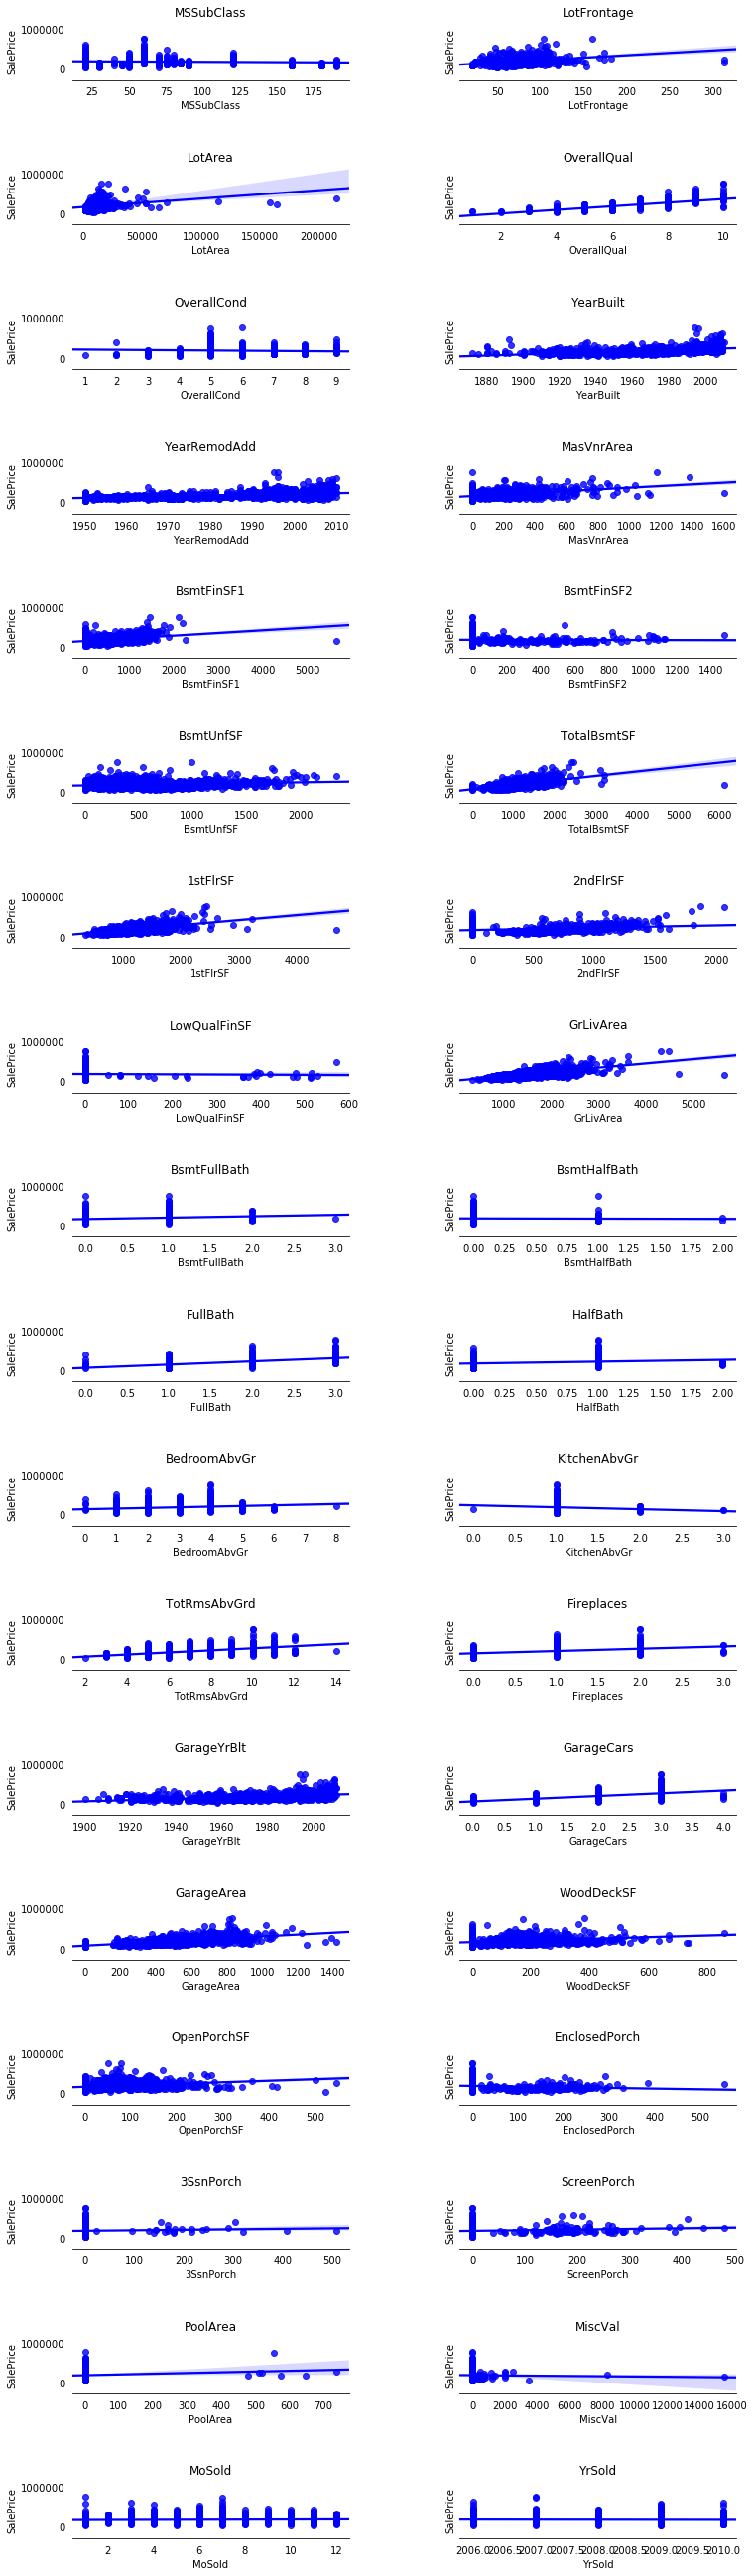

In [14]:
# Get columns that are most correlated to SalePrice to scatter plot them
testing_columns = corrmat.loc[(corrmat.index != 'SalePrice'), (corrmat.SalePrice > 0)].index

# Count subplots, total columns of plot, and total rows of plots
subplot_count = int(len(testing_columns))
col_count = 2
row_count = int((subplot_count/col_count)+1)

# Initiate the subplots
fig, axes = plt.subplots(nrows=row_count, 
                         ncols=col_count, 
                         sharey=True, 
                         figsize=(12,row_count*2), 
                         squeeze=False)
axes_list = [item for sublist in axes for item in sublist] 
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
iter_col_count = 0
iter_row_count = 0

# Loop through all columns to create a subplot for each
for i in testing_columns:
    ax = axes_list.pop(0)
    ax = sns.regplot(train_X[i],
                     train_y,
                     ax=axes[iter_row_count][iter_col_count],
                     color='blue'
                    )
    if iter_col_count == col_count - 1:
        iter_col_count = 0
        iter_row_count = iter_row_count + 1
    else:
        iter_col_count = iter_col_count + 1
    ax.set_title(i)
    ax.tick_params(which='both', bottom='off', left='off',
                   right='off', top='off'
                  )
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# delete anything we didn't use
for ax in axes_list:
    ax.remove()

**Plot sales price against Living Area sliced by Overall Quality**

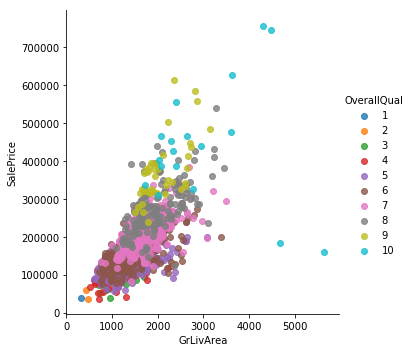

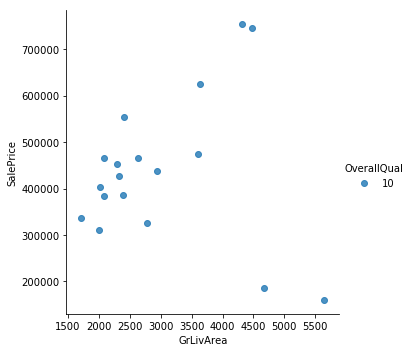

In [15]:
# Check out 
explore_data = train_X.copy()
explore_data['SalePrice'] = train_data.SalePrice

sns.lmplot(x='GrLivArea', y='SalePrice', hue='OverallQual',
           #markers=['o', 'x', '*'], 
           data=explore_data, fit_reg=False)

sns.lmplot(x='GrLivArea', y='SalePrice', hue='OverallQual',
           #markers=['o', 'x', '*'], 
           data=explore_data.loc[explore_data['OverallQual'] == 10], fit_reg=False)

**Run outlier detection on Overall Quality of 10**

From the chart above we can clearly see that there are a few outliers for quality 10 so we'll run the Local Outlier Factor to detect these outliers. (anything with a -1 is an outlier)

In [16]:
# detect outliers
outlier_detect = explore_data.loc[explore_data['OverallQual'] == 10]
outlier_detect = outlier_detect[['SalePrice','GrLivArea']]
outlier_detect['outlier'] = LocalOutlierFactor(n_neighbors=20).fit_predict(outlier_detect)
print(outlier_detect)

      SalePrice  GrLivArea  outlier
58       438780       2945        1
185      475000       3608        1
224      386250       2392        1
389      426000       2332        1
440      555000       2402        1
515      402861       2020        1
523      184750       4676        1
583      325000       2775        1
591      451950       2296       -1
691      755000       4316        1
825      385000       2084        1
994      337500       1718        1
1169     625000       3627        1
1182     745000       4476        1
1243     465000       2076       -1
1298     160000       5642        1
1373     466500       2633        1
1442     310000       2007        1


**Remove the outliers from our data set**

In [17]:
# remove outliers from primary training data sets
outliers = outlier_detect.loc[outlier_detect['outlier']==-1].index.values
print('Shape of data prior to removal')
print(train_X.shape)
print(train_y.shape)
train_X.drop(outliers, inplace=True)
train_y.drop(outliers, inplace=True)
print('Shape of data after removal')
print(train_X.shape)
print(train_y.shape)

Shape of data prior to removal
(1460, 36)
(1460,)
Shape of data after removal
(1458, 36)
(1458,)


**Check for skew in the sales price vs transform with log**

Text(0.5, 0, 'Log SalePrice')

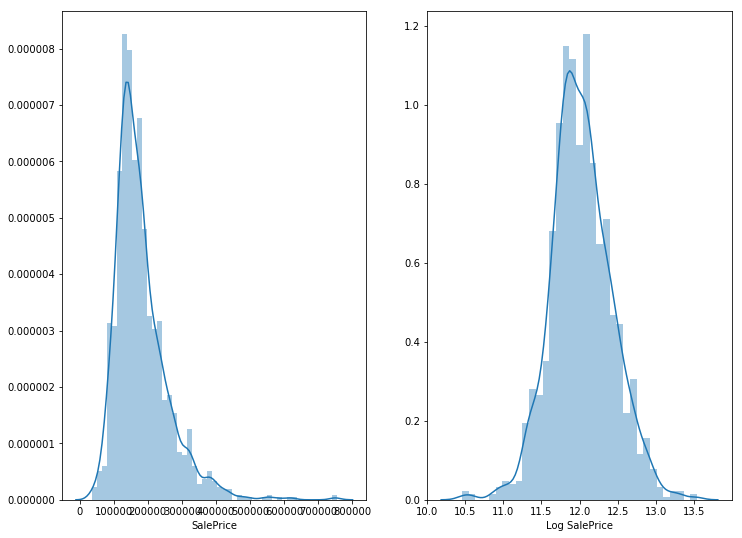

In [18]:
plt.subplots(figsize=(12,9))
plt.subplot(1, 2, 1)
sns.distplot(train_y)

plt.subplot(1, 2, 2)
sns.distplot(np.log1p(train_y))
plt.xlabel('Log SalePrice')

In [19]:
# perform log transformation to reduce skew
#train_y = np.log1p(train_y)

# 3. Feature engineering

**Sum multiple features together to get overall totals**

In [20]:
# Add Total SF
features_to_sum = ['TotalBsmtSF','1stFlrSF','2ndFlrSF']
train_X['newTotalSF'] = train_X[features_to_sum].sum(axis=1)
test_X['newTotalSF'] = test_X[features_to_sum].sum(axis=1)

# Add Total Finished SF
#features_to_sum = ['BsmtFinSF1','BsmtFinSF2','1stFlrSF','2ndFlrSF']
#train_X['newFinTotalSF'] = train_X[features_to_sum].sum(axis=1)
#test_X['newFinTotalSF'] = test_X[features_to_sum].sum(axis=1)

# Add Total Bathrooms
#features_to_sum = ['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath']
#train_X['newTotalBath'] = train_X[features_to_sum].sum(axis=1)
#test_X['newTotalBath'] = test_X[features_to_sum].sum(axis=1)

# Add Total Porch SF
#features_to_sum = ['OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch','WoodDeckSF']
#train_X['newTotalPorchSF'] = train_X[features_to_sum].sum(axis=1)
#test_X['newTotalPorchSF'] = test_X[features_to_sum].sum(axis=1)

# 4. Modeling
Build best model and predict final results

**Create pipeline with models**

In [21]:
# create pipeline
my_pipeline = make_pipeline(Imputer(),
                            XGBRegressor(n_estimators=1000, 
                                         learning_rate=0.05)
                           )

**Score pipeline**

In [22]:
# Scoring - Root Mean Squared Error
def rmse_score(model,X,y):
    return np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))

# Scoring - Mean Absolute Error
def mae_score(model,X,y):
    return -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=5)

# score the pipeline
#mae = mae_score(my_pipeline,train_X,train_y)
#print('Mean Absolute Error: {}'.format(mae.mean()))
#rmse = rmse_score(my_pipeline,train_X,train_y)
#print('Root Mean Squared Error: {}'.format(rmse.mean()))
rmse_log = rmse_score(my_pipeline,train_X,np.log1p(train_y))
print('Root Mean Squared Error with log tranform: {}'.format(rmse_log.mean()))

Root Mean Squared Error with log tranform: 0.134337289759167


**Train the model**

In [23]:
# train the model
model = my_pipeline.fit(train_X, train_y)

# Use the model to make predictions
final_predicted_prices = model.predict(test_X)

# transform log values for sale price back into regular sale price
#final_predicted_prices = np.expm1(final_predicted_prices)

# round final prices
final_predicted_prices = [round(x,2) for x in final_predicted_prices]

# look at the predicted prices to ensure we have something sensible.
print(final_predicted_prices[:5])

[131516.4, 154724.53, 188659.94, 197085.05, 176719.1]


**Permutation Importance - Importance of various features**

In [24]:
#TO DO - if I want this to work it seems I'll need to concentrate on only numeric values

#import eli5
#from eli5.sklearn import PermutationImportance

# I'm using training data here for now since I didn't take the time to split out validation data 
#perm = PermutationImportance(model, random_state=1).fit(train_X, train_y)

#eli5.show_weights(perm, feature_names = train_X.columns.tolist())

# 5. Submit results

In [ ]:
# submit results
my_submission = pd.DataFrame({'Id': test_data.Id, 'SalePrice': final_predicted_prices})
my_submission.to_csv('submission.csv', index=False)